### Kaggle competition 
<p> <a href=https://www.kaggle.com/c/widsdatathon2019 target="_blank"> This is the link to the competition </a></p>
#### I used PyTorch libraries for this work. 
<p> <a href=https://pytorch.org/ target="_blank">This is the official PyTorch webpage</a></p>
<a href https://www.kaggle.com/c/widsdatathon2019> This is the link to the competition </a>



In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
#This works is developed using parts of Rachel's V3 code. Thanks Rachel.
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc    
import seaborn as sns
import os, shutil, random
import json
from collections import OrderedDict
import cv2
import glob
from PIL import Image
from skimage.io import imread_collection
import time
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from skimage import data 
import torch
from torch.utils.data import random_split
from torch import nn
from torch import optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import datasets, transforms, models
import copy

import scikitplot as skplt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['traininglabels.csv', 'leaderboard_test_data', 'train_images', 'leaderboard_holdout_data', 'SampleSubmission.csv']


In [2]:
#defining directories
data_dir = "../input"
train_dir = "../input/train_images/train_images"
test_dir = "../input/leaderboard_test_data/leaderboard_test_data"
lb_holdout_dir = "../input/leaderboard_holdout_data/leaderboard_holdout_data"
labels_dir = "../input/traininglabels.csv"
df = pd.read_csv(labels_dir)
df['Image_path'] = [os.path.join(train_dir,img) for img in df['image_id']]
df.head()

,image_id,has_oilpalm,score,Image_path
0,img_000002017.jpg,0,0.7895,../input/train_images/train_images/img_0000020...
1,img_000012017.jpg,0,1.0000,../input/train_images/train_images/img_0000120...
2,img_000022017.jpg,0,1.0000,../input/train_images/train_images/img_0000220...
3,img_000072017.jpg,0,1.0000,../input/train_images/train_images/img_0000720...
4,img_000082017.jpg,0,1.0000,../input/train_images/train_images/img_0000820...


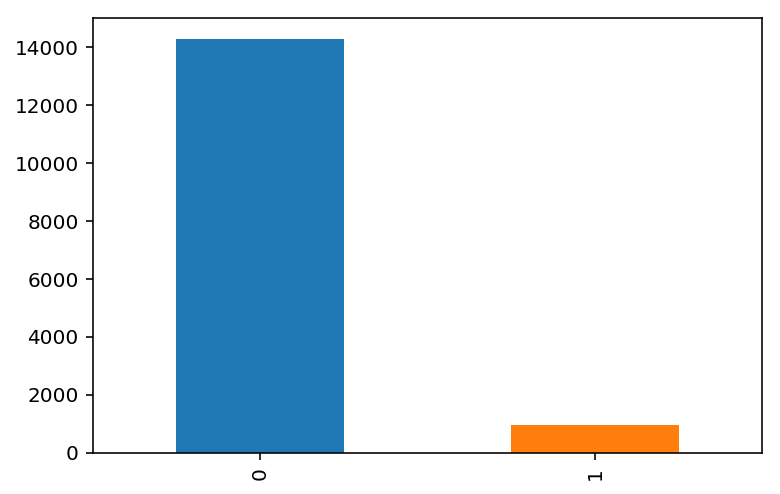

In [3]:
#unbalanced dataset
df["has_oilpalm"].value_counts().plot(kind="bar")

In [4]:
#df[(df['has_oilpalm'] == 0) & (df['score'] >0.7)].describe()
df[(df['has_oilpalm'] == 0)].describe()

,has_oilpalm,score
count,14302.0,14302.000000
mean,0.0,0.956711
std,0.0,0.107247
min,0.0,0.388700
25%,0.0,1.000000
50%,0.0,1.000000
75%,0.0,1.000000
max,0.0,1.000000


In [5]:
#df[(df['has_oilpalm'] == 1) & (df['score'] >0.7)].describe()
df[(df['has_oilpalm'] == 1)].describe()

,has_oilpalm,score
count,942.0,942.000000
mean,1.0,0.941472
std,0.0,0.136876
min,1.0,0.394400
25%,1.0,1.000000
50%,1.0,1.000000
75%,1.0,1.000000
max,1.0,1.000000


In [6]:
has_oilpalm_hp = df[(df['has_oilpalm'] == 1)].reset_index(drop=True)
len(has_oilpalm_hp) 

942

In [7]:
no_oilpalm_hp = df[(df['has_oilpalm'] == 0)].reset_index(drop=True)
len(no_oilpalm_hp)   #one too many..unbalanced

14302

In [8]:
#quadruplicating the has_oilpal_hp (making up for more 1s)
has_oilpalm_hp_x4=pd.concat([has_oilpalm_hp, has_oilpalm_hp, has_oilpalm_hp, has_oilpalm_hp])
has_oilpalm_hp_x4.reset_index(drop=True)
has_oilpalm_hp_x8=pd.concat([has_oilpalm_hp_x4, has_oilpalm_hp_x4]).reset_index(drop=True)
has_oilpalm_hp_x16=pd.concat([has_oilpalm_hp_x8, has_oilpalm_hp_x8]).reset_index(drop=True)
len(has_oilpalm_hp_x16)

15072

In [9]:
#New balanced and fatty dataset
balanced_sample=pd.concat([has_oilpalm_hp_x16, no_oilpalm_hp]).reset_index(drop=True)
len(balanced_sample)

29374

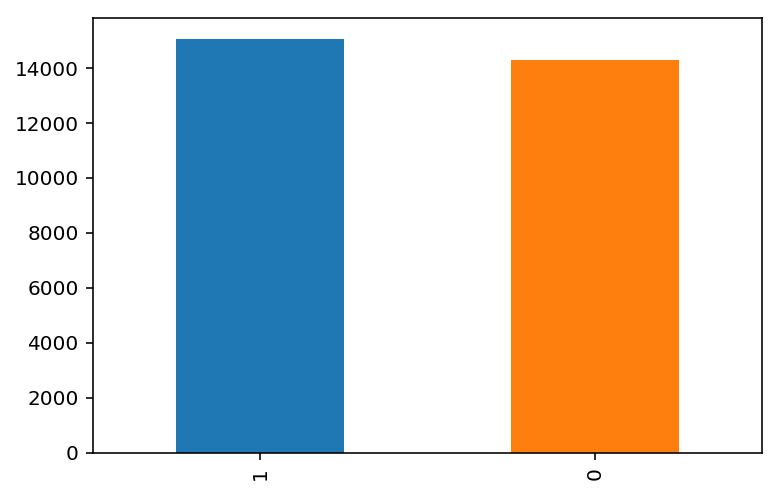

In [10]:
#BALLANCING SAMPLE LABELS
balanced_sample["has_oilpalm"].value_counts().plot(kind="bar")  #yep getting there (approach inspired by fastai MOOC)

In [11]:
#creating test_sample and train_sample from balanced_sample
train_sample, test_sample = train_test_split(balanced_sample, test_size=0.2)
train_sample.reset_index(drop=True);
test_sample.reset_index(drop=True);
#creating valid_sample
valid_sample = train_sample.sample(frac=0.2, random_state=1)
valid_sample.reset_index(drop=True);
print('train_sample\'s, valid_sample\'s and test_sample\'s lengths are {} {} {}, respectively'. format(len(train_sample), len(valid_sample), len(test_sample)))


train_sample's, valid_sample's and test_sample's lengths are 23499 4700 5875, respectively


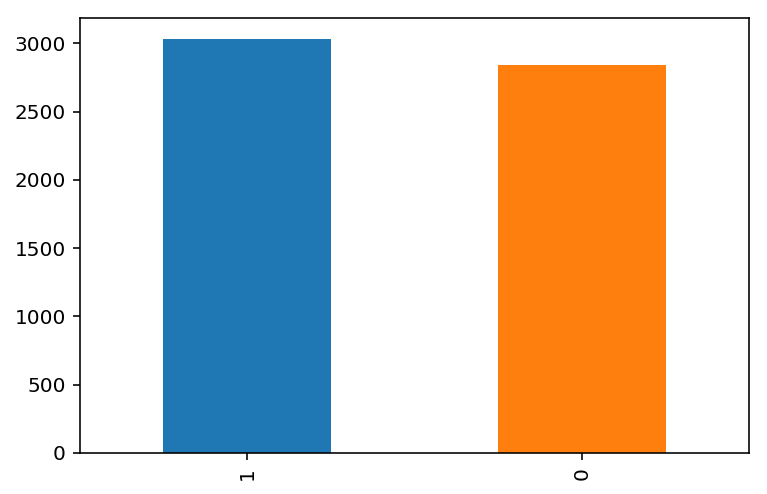

In [12]:
#How the test_sample looks like
test_sample["has_oilpalm"].value_counts().plot(kind="bar")

In [13]:
# class to create a custom dataset from Rachel
class Dataset:
    def __init__(self, dataframe, img_path, transform=None):
        """
        csv_path: path to csv file
        img_path: path to the image folder
        transform: torch transforms
        """
        # Transforms
        self.transforms = transform
        # Image folder path
        self.img_path = img_path
        # Ceate df from csv file
        self.data = dataframe
        # Images
        self.images = self.data["Image_path"]
        # Labels
        self.labels = self.data["has_oilpalm"]
        # Classes
        self.classes = set(self.labels)
        # Number of classes
        self.num_classes = len(self.classes)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # Get image name from df
        img_path = self.images.iloc[index]
        # Open image
        img = Image.open(img_path)
        # Transform image
        if self.transforms:
            img = self.transforms(img)
        # Get labels
        label = self.labels.iloc[index]
        sample = {'image': img, 'label': int(label)}

        
        return sample

In [14]:
#From Rachel
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 5))
    else:
        fig, ax = plt.subplots(figsize=ax)
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    ax.set_title("{}".format(title))
    ax.grid(False)
    plt.axis('off')
    ax.imshow(image)
    
    return ax

In [15]:
#Define transforms for training and validadtion datasets (icode)
Normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

data_transforms= {"training": transforms.Compose([transforms.RandomSizedCrop(224),
                                                   #transforms.RandomVerticalFlip(),#see PaulBruce
                                                   #transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
                                                   transforms.ToTensor(),
                                                   Normalize]),

                 "validation": transforms.Compose([transforms.Scale(256),
                                                   transforms.CenterCrop(224),      
                                                   transforms.ToTensor(),
                                                   Normalize]),
                  "testing": transforms.Compose([transforms.Scale(256),
                                                   transforms.CenterCrop(224),      
                                                   transforms.ToTensor(),
                                                   Normalize]),
                 }

/opt/conda/lib/python3.6/site-packages/torchvision/transforms/transforms.py:563: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  "please use transforms.RandomResizedCrop instead.")
/opt/conda/lib/python3.6/site-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")
/opt/conda/lib/python3.6/site-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


os.path.abspath("test_sample")
#creating a current working directory path
test_dir = '../kaggle/working/test_sample'

In [16]:
image_datasets = {'train_dataset':Dataset(dataframe=train_sample, img_path=train_dir, transform=data_transforms['training']),
                  'valid_dataset':Dataset(dataframe=valid_sample, img_path=train_dir, transform=data_transforms['validation']),
                  'test_dataset':Dataset(dataframe=test_sample, img_path=train_dir, transform=data_transforms['testing'])}

In [17]:
batch_size = 8
dataloaders = {"train": torch.utils.data.DataLoader(image_datasets["train_dataset"], batch_size = batch_size, shuffle=True),
               "valid": torch.utils.data.DataLoader(image_datasets["valid_dataset"], batch_size = batch_size, shuffle=True),
               "test": torch.utils.data.DataLoader(image_datasets["test_dataset"], batch_size = batch_size, shuffle=True)} 

tensor([1, 0, 0, 1, 1, 0, 1, 1])


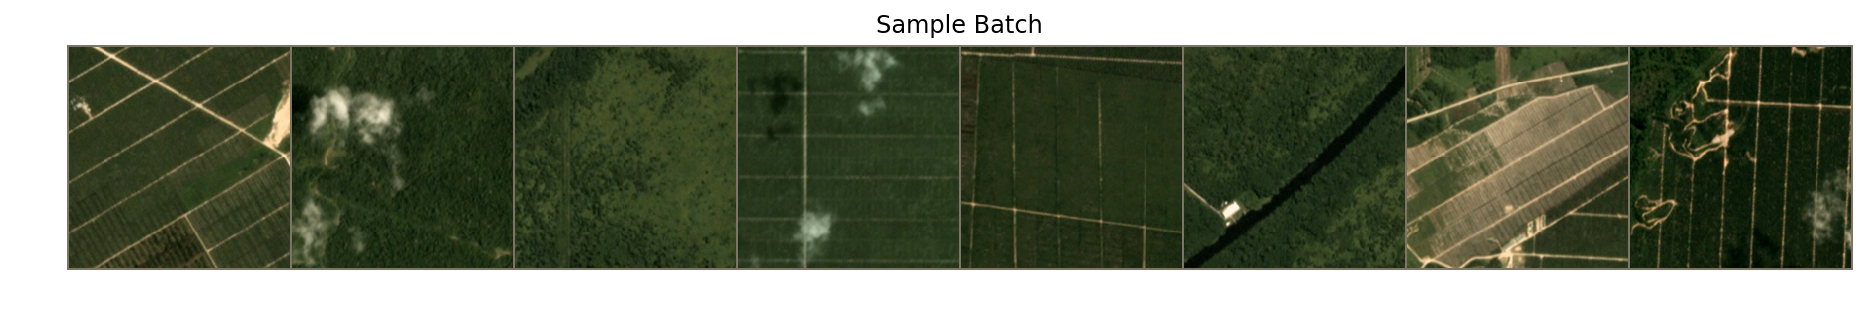

In [18]:
# display batch of 8 images from test_sample
dataiter = iter(dataloaders['test'])
sample_batch = dataiter.next()
imshow(torchvision.utils.make_grid(sample_batch['image']),ax =(16,6), title="Sample Batch")
print(sample_batch['label'])

In [19]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")   #agnostic way
device

device(type='cuda', index=0)

In [20]:
#Chosen Model 
import torchvision
from torchvision import models
model=models.resnet50(pretrained=False)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [21]:
# Model alexnet 
#def model():
model = models.resnet50(pretrained=False)
# Freezing parameters
for param in model.parameters():
    param.requires_grad = False
#removing classifier 
#classifier = nn.Sequential(*list(model.classifier.children())[:-1])
# replacing it with a custom classifier
fc = nn.Sequential(nn.Linear(in_features=2048, out_features=2, bias=True),
                nn.LogSoftmax(dim=1))
#Attaching custom classifier to the model
model.fc = fc

In [22]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [23]:
#loss function
criterion = nn.NLLLoss()

#SGD optimizer
optimizer = optim.SGD(model.fc.parameters(), lr= 1e-4, momentum=0.9)


In [24]:
#scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

In [25]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")   #agnostic way
device

device(type='cuda', index=0)

In [26]:
model.to(device);

In [27]:
epochs=3
batch_size = 8
check_every =100
# Start clean by setting gradients of all parameters to zero. 
model.zero_grad()

dataset_len = len(dataloaders["train"].batch_sampler)
total_val_images = len(dataloaders["valid"].batch_sampler) * dataloaders["valid"].batch_size

print(f'Using the {device} device to train.')
print(f'Training on {dataset_len} batches of {dataloaders["train"].batch_size}.')
print(f'Average loss and accuracy for epoch every {check_every} batches.')

for e in range(epochs):
    e_loss = 0
    prev_chk = 0
    total = 0
    correct = 0
    print(f'\nEpoch {e+1} of {epochs}\n----------------------------')
    for ii, (image, label) in enumerate(dataloaders["train"]):
        images = sample_batch['image'].to(device)
        labels = sample_batch['label'].to(device)
        
        # Set gradients of all parameters to zero. 
        optimizer.zero_grad()
        outputs = model.forward(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        e_loss += loss.item()
        #accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Keep a running total of loss for
        # this epoch
        itr = (ii + 1)
        if itr % check_every == 0:
            avg_loss = f'avg. loss: {e_loss/itr:.4f}'
            acc = f'accuracy: {(correct/total) * 100:.2f}%'
            print(f'  Batches {prev_chk:03} to {itr:03}: {avg_loss}, {acc}.')
            prev_chk = (ii + 1)
    
    # Validation
    e_valid_correct = 0
    e_valid_total = 0
     # Disabling gradient calculation
    with torch.no_grad():
        for ii, (images, labels) in enumerate(dataloaders["valid"]):
            images = sample_batch['image'].to(device)
            labels = sample_batch['label'].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            e_valid_total += labels.size(0)
            e_valid_correct += (predicted == labels).sum().item()
        print(f"\n\tValidating for epoch {e+1}...")
        correct_perc = 0
        if e_valid_correct > 0:
            correct_perc = (100 * e_valid_correct // e_valid_total)
        print(f'\tAccurately classified {correct_perc:d}% of {total_val_images} images.')

print('Done...')

torch.save(model, 'resnet50.pth')

Using the cuda:0 device to train.
Training on 2938 batches of 8.
Average loss and accuracy for epoch every 100 batches.

Epoch 1 of 3
----------------------------
  Batches 000 to 100: avg. loss: 0.5150, accuracy: 63.00%.
  Batches 100 to 200: avg. loss: 0.4512, accuracy: 79.69%.
  Batches 200 to 300: avg. loss: 0.4048, accuracy: 86.46%.
  Batches 300 to 400: avg. loss: 0.3683, accuracy: 89.84%.
  Batches 400 to 500: avg. loss: 0.3386, accuracy: 91.88%.
  Batches 500 to 600: avg. loss: 0.3139, accuracy: 93.23%.
  Batches 600 to 700: avg. loss: 0.2929, accuracy: 94.20%.
  Batches 700 to 800: avg. loss: 0.2749, accuracy: 94.92%.
  Batches 800 to 900: avg. loss: 0.2593, accuracy: 95.49%.
  Batches 900 to 1000: avg. loss: 0.2455, accuracy: 95.94%.
  Batches 1000 to 1100: avg. loss: 0.2333, accuracy: 96.31%.
  Batches 1100 to 1200: avg. loss: 0.2224, accuracy: 96.61%.
  Batches 1200 to 1300: avg. loss: 0.2126, accuracy: 96.88%.
  Batches 1300 to 1400: avg. loss: 0.2037, accuracy: 97.10%.
  

In [28]:
#How the model works on the test_sample 
#(NB it's not a prediction; It should work as per validation_sample 
# as test and validation are portion of the original train_sample)
correct = 0
total = 0
total_images = len(dataloaders["test"].batch_sampler) * dataloaders["test"].batch_size

# Disabling gradient calculation
with torch.no_grad():
    for ii, (image, label) in enumerate(dataloaders["test"]):
        images = sample_batch['image'].to(device)
        labels = sample_batch['label'].to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accurately classified {(100 * correct // total):d}% of {total_images} images.')

Accurately classified 100% of 5880 images.


In [29]:
#From Rachel
# repeating training and cross checking accuracy+saving checkpoint for resnet50
dataloaders= {"train":dataloaders['train'], "valid":dataloaders['valid']}
dataset_sizes = {"train":len(dataloaders['train']), "valid":len(dataloaders['valid'])}

def train_model(dataloaders, dataset_sizes, model, criteria, optimizer, scheduler, num_epochs=25, device='cuda'):
    model.to(device) # send to gpu
    # track time elapsed
    since = time.time()
    # track our loss history over the epochs for plotting
    loss_history = []
    counter = []
    count = 0 
    # save our best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for batch_idx, sample_batched in enumerate(dataloaders[phase]):
                inputs = sample_batch['image'].to(device)
                labels = sample_batch['label'].to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    probs,preds = torch.max(outputs, dim=1)
                    loss = criteria(outputs, labels.cuda())

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += np.exp(loss.item()) * inputs.size(0) 
                running_corrects += torch.mean((preds == labels.data).type(torch.FloatTensor))
                
                # add add loss to loss_history for plotting loss over time
                if batch_idx % 10 == 0:
                    count += 10
                    counter.append(count)
                    loss_history.append(loss.item())
                    
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    plt.plot(counter,loss_history)
    plt.show()
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Epoch 0/2
----------
train Loss: 8.0921 Acc: 1.0000
valid Loss: 8.0817 Acc: 1.0000

Epoch 1/2
----------
train Loss: 8.0709 Acc: 1.0000
valid Loss: 8.0651 Acc: 1.0000

Epoch 2/2
----------
train Loss: 8.0576 Acc: 1.0000
valid Loss: 8.0540 Acc: 1.0000

Training complete in 17m 17s
Best val Acc: 1.000000


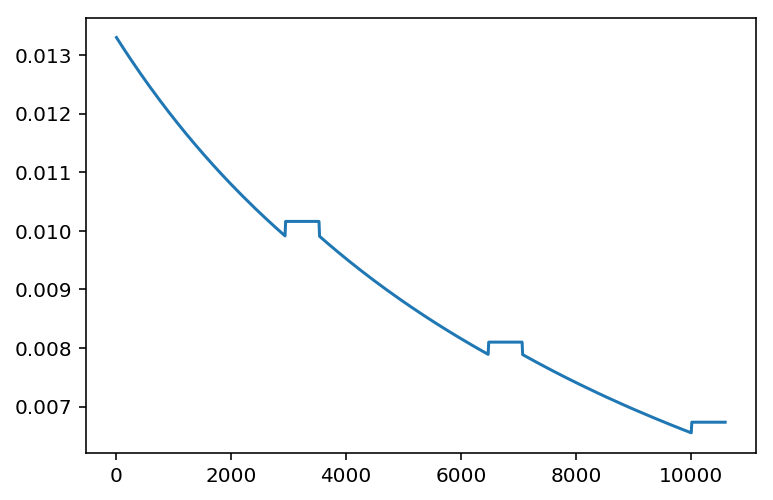

In [30]:
#from Rachel
trained_model = train_model(dataloaders = dataloaders,
                            dataset_sizes = dataset_sizes,
                            model=model,
                            criteria=criterion,
                            optimizer=optimizer,
                            scheduler=scheduler,
                            num_epochs=epochs,
                            device=device)

In [31]:
# predict 
def predict(dataloader, model):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    dataiter = iter(dataloader)
    sample_batched = next(dataiter)
    images = sample_batch['image'].cuda()
    labels = sample_batch['label']
    images.cpu().numpy()
    # compute predicted outputs by passing inputs to the model
    model.eval() # eval mode
    # get sample outputs
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    labels = labels.cpu().detach().numpy()
    preds = preds.cpu().detach().numpy()
    probs = outputs.cpu().detach().numpy()
    # return preds, labels, images
    return preds,labels,probs, images.cpu()

In [32]:
# predict class
preds, labels, probs, images = predict(dataloaders["valid"], trained_model)

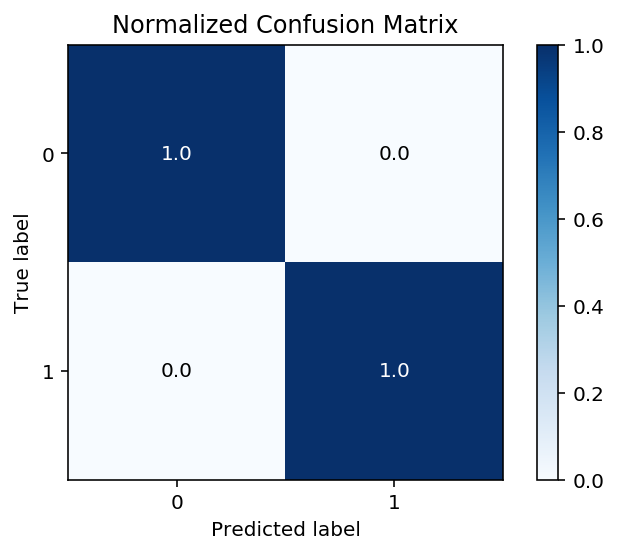

In [33]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(labels, preds, normalize=True)
plt.show()